In [1]:
# !pip install torch

In [2]:
# !pip install torchvision

In [2]:
import pandas as pd
import numpy as np
import math
from torch import nn
import torch.nn.functional as F
import torch
import torchvision

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [3]:
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target
feature_names = dataset.feature_names
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=13, test_size=0.25)

In [4]:
class MyDataset(Dataset):
 
    def __init__(self, X, y):
                
        y = np.expand_dims(y, axis=1)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [5]:
train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val) 

In [6]:
train_data = DataLoader(train_ds, batch_size=32, shuffle=True)
val_data = DataLoader(val_ds, batch_size=32)

In [7]:
for batch, label in train_data:
    print(batch.shape, label.shape)
    break


torch.Size([32, 8]) torch.Size([32, 1])


In [24]:
class RegressionModel(nn.Module):
     
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  
        loss = F.mse_loss(out, targets) 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    
        loss = F.mse_loss(out, targets)   
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'val_loss': epoch_loss.item()}
       
    def epoch_end(self, epoch, result):
        if (epoch+1) % 10 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}, train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}")

In [46]:
class Net1(RegressionModel):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.dp1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.bn2 = nn.BatchNorm1d(2 * hidden_dim)
        self.dp2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.dp3 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.dp1(x)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.bn2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.dp3(x)
        x = self.fc4(x)
        x = F.leaky_relu(x, 0.05)
        return x


In [40]:
class Net2(RegressionModel):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        return x

In [41]:
class Net3(RegressionModel):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.dp1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.dp1(x)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        return x

In [42]:
@torch.no_grad()
def evaluate(model, val_data):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_data]
    return model.validation_epoch_end(outputs)

def fit (epochs, train_data, val_data, model, optimizer, lr):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), lr=lr)
 
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
               
        for batch in train_data:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
              
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_data)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [43]:
def plot_losses(history, optimizer):
    losses_train = [x['train_loss'] for x in history]
    losses_val = [x['val_loss'] for x in history]
    plt.plot(losses_train, '-o', label=f'{optimizer}, train_loss')
    plt.plot(losses_val, '-x', label=f'{optimizer}, val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss vs. Number of Epochs');

In [14]:
optimizers = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]

Epoch 10, train_loss: 0.4401, val_loss: 0.4929
Epoch 20, train_loss: 0.4050, val_loss: 0.4898
Epoch 30, train_loss: 0.3945, val_loss: 0.5067
Epoch 40, train_loss: 0.3883, val_loss: 0.3840
Epoch 50, train_loss: 0.3792, val_loss: 0.3496
Epoch 60, train_loss: 0.3809, val_loss: 0.3757
Epoch 70, train_loss: 0.3718, val_loss: 0.3425
Epoch 80, train_loss: 0.3616, val_loss: 0.3349
Epoch 90, train_loss: 0.3669, val_loss: 0.4122
Epoch 100, train_loss: 0.3682, val_loss: 0.3241
Epoch 10, train_loss: 0.4428, val_loss: 0.4733
Epoch 20, train_loss: 0.4561, val_loss: 0.4371
Epoch 30, train_loss: 0.4607, val_loss: 0.3483
Epoch 40, train_loss: 0.4522, val_loss: 0.3967
Epoch 50, train_loss: 0.4686, val_loss: 0.4050
Epoch 60, train_loss: 0.4460, val_loss: 0.3708
Epoch 70, train_loss: 0.4511, val_loss: 0.3433
Epoch 80, train_loss: 0.4359, val_loss: 0.4291
Epoch 90, train_loss: 0.4408, val_loss: 0.4629
Epoch 100, train_loss: 0.4445, val_loss: 0.3110
Epoch 10, train_loss: 0.5104, val_loss: 0.3617
Epoch 20, t

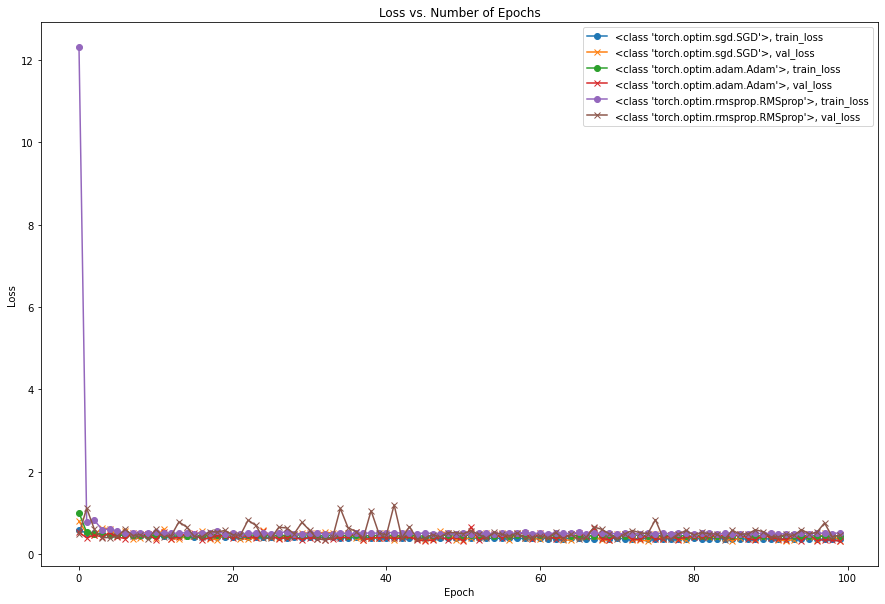

In [47]:
plt.figure(figsize=(15, 10))

for opt in optimizers:
    net = Net1(8, 256)
    epochs = 100
    lr = 0.01
    history = [evaluate(net, val_data)]
    history += fit(epochs=epochs, 
               train_data=train_data,
               val_data=val_data, 
               model=net, 
               optimizer=opt, 
               lr=lr)
    plot_losses(history[1:], opt)

Epoch 10, train_loss: 0.4787, val_loss: 0.4691
Epoch 20, train_loss: 0.4662, val_loss: 0.5405
Epoch 30, train_loss: 0.4666, val_loss: 0.4367
Epoch 40, train_loss: 0.4498, val_loss: 0.4098
Epoch 50, train_loss: 0.4540, val_loss: 0.5351
Epoch 60, train_loss: 0.4420, val_loss: 0.4093
Epoch 70, train_loss: 0.4413, val_loss: 0.5056
Epoch 80, train_loss: 0.4497, val_loss: 0.5013
Epoch 90, train_loss: 0.4370, val_loss: 0.4105
Epoch 100, train_loss: 0.4341, val_loss: 0.5140
Epoch 10, train_loss: 0.4652, val_loss: 0.5181
Epoch 20, train_loss: 0.4571, val_loss: 0.5283
Epoch 30, train_loss: 0.4586, val_loss: 0.4430
Epoch 40, train_loss: 0.4502, val_loss: 0.4734
Epoch 50, train_loss: 0.4592, val_loss: 0.4196
Epoch 60, train_loss: 0.4574, val_loss: 0.5164
Epoch 70, train_loss: 0.4543, val_loss: 0.4625
Epoch 80, train_loss: 0.4464, val_loss: 0.5327
Epoch 90, train_loss: 0.4590, val_loss: 0.4782
Epoch 100, train_loss: 0.4536, val_loss: 0.4331
Epoch 10, train_loss: 0.4578, val_loss: 0.5035
Epoch 20, t

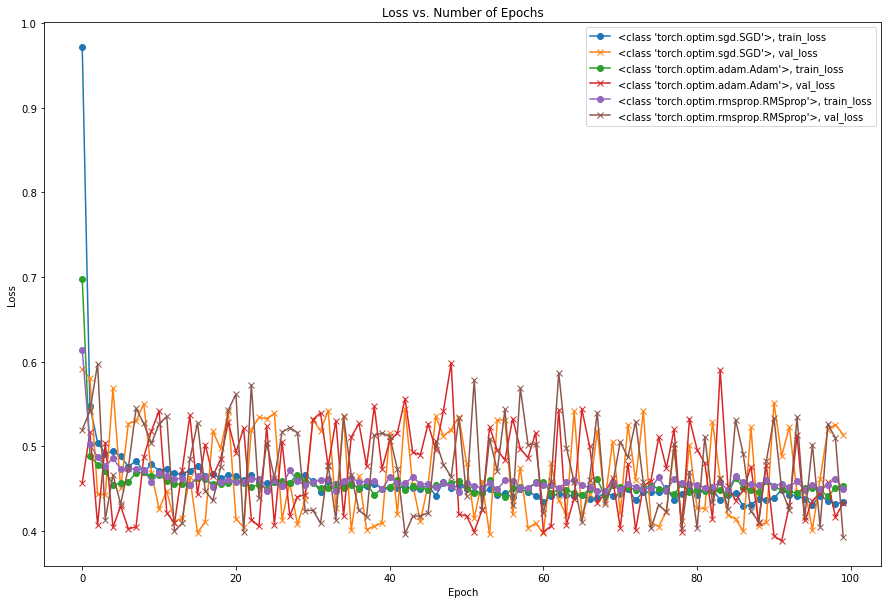

In [44]:
plt.figure(figsize=(15, 10))

for opt in optimizers:
    net = Net2(8, 64)
    epochs = 100
    lr = 0.01
    history = [evaluate(net, val_data)]
    history += fit(epochs=epochs, 
               train_data=train_data,
               val_data=val_data, 
               model=net, 
               optimizer=opt, 
               lr=lr)
    plot_losses(history[1:], opt)

Epoch 10, train_loss: nan, val_loss: nan
Epoch 20, train_loss: nan, val_loss: nan
Epoch 30, train_loss: nan, val_loss: nan
Epoch 40, train_loss: nan, val_loss: nan
Epoch 50, train_loss: nan, val_loss: nan
Epoch 60, train_loss: nan, val_loss: nan
Epoch 70, train_loss: nan, val_loss: nan
Epoch 80, train_loss: nan, val_loss: nan
Epoch 90, train_loss: nan, val_loss: nan
Epoch 100, train_loss: nan, val_loss: nan
Epoch 10, train_loss: 0.9130, val_loss: 0.9007
Epoch 20, train_loss: 1.3164, val_loss: 0.7501
Epoch 30, train_loss: 0.9108, val_loss: 0.8099
Epoch 40, train_loss: 0.8839, val_loss: 0.7728
Epoch 50, train_loss: 0.9882, val_loss: 0.8618
Epoch 60, train_loss: 1.3973, val_loss: 1.0122
Epoch 70, train_loss: 0.9734, val_loss: 0.7978
Epoch 80, train_loss: 2.9524, val_loss: 0.9060
Epoch 90, train_loss: 1.2554, val_loss: 1.0879
Epoch 100, train_loss: 21.1955, val_loss: 117.9006
Epoch 10, train_loss: 91.1624, val_loss: 8.9861
Epoch 20, train_loss: 9.4672, val_loss: 0.8171
Epoch 30, train_loss

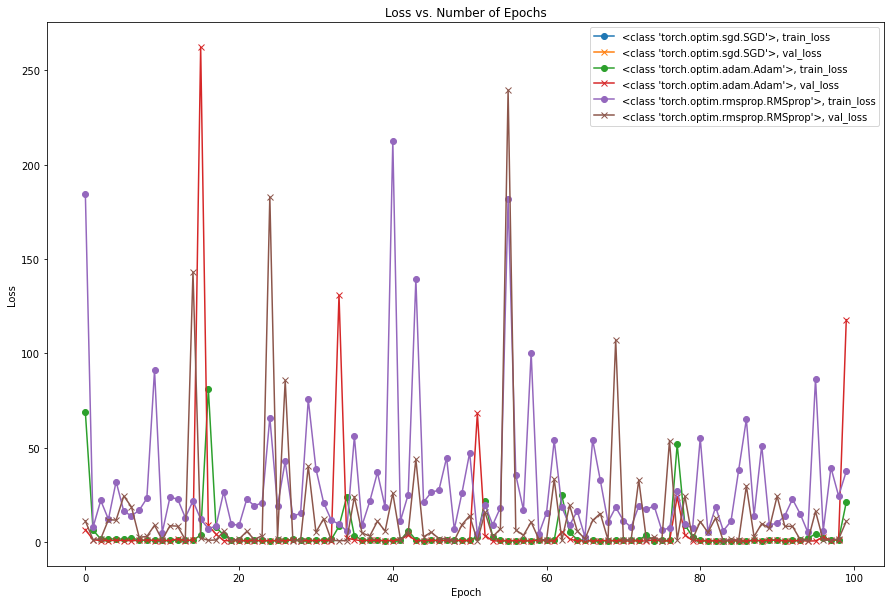

In [45]:
plt.figure(figsize=(15, 10))

for opt in optimizers:
    net = Net3(8, 64)
    epochs = 100
    lr = 0.01
    history = [evaluate(net, val_data)]
    history += fit(epochs=epochs, 
               train_data=train_data,
               val_data=val_data, 
               model=net, 
               optimizer=opt, 
               lr=lr)
    plot_losses(history[1:], opt)

Сходимость неглубоких моделей при различных оптимизаторах сравнимо плохая. Возможно, для нейросети слишком мало данных в датасете